In [1]:
#-*-coding:utf-8-*-
from GameEnv import Game2048
from DQN import DQN
import random
import copy

def check_one_game(gameEnv,debug):
    gameEnv.reset()
    flag = False
    observation = copy.deepcopy(gameEnv.matrix)
    while True:
        if debug:gameEnv.display()

        action = random.choice(["a","w","d","s"])
        observation_, reward, done = gameEnv.step(action)
        flag = True if observation_ == observation else False
        observation = copy.deepcopy(observation_)
        if debug:print("_________________________________________")
        if done:
            if debug:gameEnv.display()
            if debug:print("this_score_____________________:",gameEnv.score)
            break
    return gameEnv.score

gameEnv = Game2048()
gameEnv.grid_n = 2

# 在线Monto-calo流程图

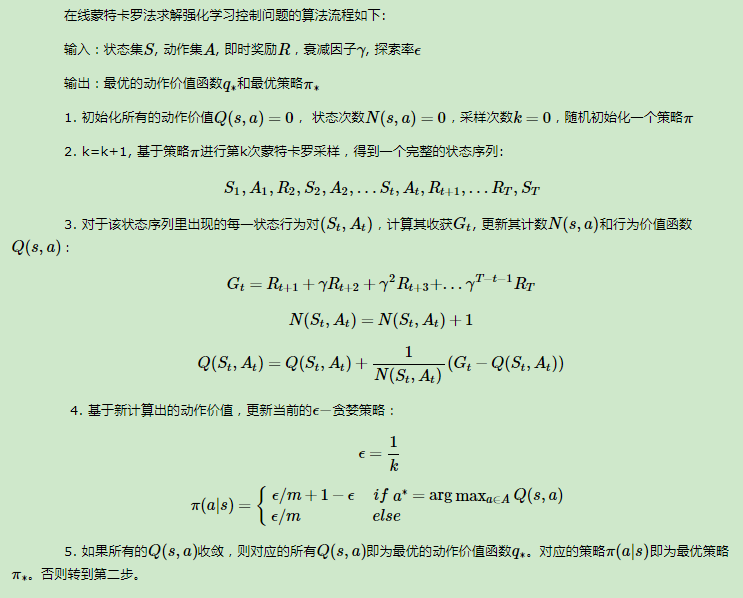

In [121]:
import itertools
import numpy as np
def transform(stauts):
    return np.array(eval(status)).reshape(2,2).tolist()

def transform_key(status):
    return str(tuple(np.array(status).reshape(-1)))

def e_greedy(action,e):
    if random.random() < e:
        return random.choice(["a","s","w","d"])
    else:
        return action

def monto_calo(gameEnv):
    # 初始化
    step = 0
    e = 0.6 ** (step / 1000)
    q_value = {}
    q_value_before = {}
    N_num = {}
    policy = {}
    policy_before = {}
    k = 0
    for s in list(itertools.permutations([0,0,0,2,2,2,4,4,4,8,8,8,16,16,16,32],4)):
        for a in ["a","s","w","d"]:
            ss = str(s)
            policy[ss] = random.choice(["a","s","w","d"])
            ss += "_" + a
            q_value[ss] = 0
            q_value_before[ss] = 0
            N_num[ss] = 0


    while True:
        # monto-calo sample
        status_list = []
        action_list = []
        reward_list = []
        gameEnv.reset()
        flag = False
        observation = copy.deepcopy(gameEnv.matrix)
        while True:
            if flag:
                action = random.choice(["a","s","w","d"])
            else:
                action = e_greedy(policy[transform_key(gameEnv.matrix)],e)
            status_list.append(copy.deepcopy(gameEnv.matrix))
            action_list.append(action)
            observation_, reward, done = gameEnv.step(action)
            flag = True if observation_ == observation else False
            observation = copy.deepcopy(observation_)
            reward_list.append(reward)
            if done:
                break

        # update Q and N
        for i in range(len(status_list)):
            key = transform_key(status_list[i]) + "_" + action_list[i]
            Gt = np.sum(reward_list[i:])
            N_num[key] += 1
            q_ori = q_value[key]
            q_value[key] = q_ori + (1.0 / N_num[key]) * (Gt - q_ori)

        # update policy
        for s in policy.keys():
            t_value_max = 0
            t_action = "a"
            for a in ["a","s","w","d"]:
                if q_value[s + "_" + a] > t_value_max:
                    t_value_max = q_value[s + "_" + a]
                    t_action = a
            if t_value_max == 0:
                t_action = random.choice(["a","s","w","d"])
            policy[s] = e_greedy(t_action,e)

        # judge out
        if (policy == policy_before and step > 0) or step > 100000:
            break
        else:
            if step % 1000 == 0:
                print "step:%d e:%f"%(step,e)
                evaluate(gameEnv,policy)
#                 t_sum = 0
#                 for s in q_value_before.keys():
#                     t_sum += abs(q_value_before[s] - q_value[s])
#                 print "step:",step," loss:",t_sum
        policy_before = copy.deepcopy(policy)
        q_value_before = copy.deepcopy(q_value)
        step += 1
        e = 0.6 ** (step / 1000)
    print "over"
    return policy,q_value

In [122]:
policy,q_value = monto_calo(gameEnv)

step:0 e:1.000000
avg:23 max:152 min:0 
step:1000 e:0.600000
avg:36 max:160 min:4 
step:2000 e:0.360000
avg:37 max:164 min:4 
step:3000 e:0.216000
avg:41 max:160 min:0 
step:4000 e:0.129600
avg:48 max:168 min:0 
step:5000 e:0.077760
avg:51 max:168 min:12 
step:6000 e:0.046656
avg:53 max:168 min:4 
step:7000 e:0.027994
avg:52 max:172 min:12 
step:8000 e:0.016796
avg:56 max:168 min:12 
step:9000 e:0.010078
avg:56 max:168 min:12 
step:10000 e:0.006047
avg:56 max:172 min:12 
step:11000 e:0.003628
avg:58 max:168 min:12 
step:12000 e:0.002177
avg:56 max:164 min:12 
step:13000 e:0.001306
avg:57 max:168 min:12 
step:14000 e:0.000784
avg:56 max:172 min:12 
step:15000 e:0.000470
avg:57 max:168 min:12 
step:16000 e:0.000282
avg:57 max:168 min:12 
step:17000 e:0.000169
avg:58 max:168 min:12 
step:18000 e:0.000102
avg:57 max:164 min:12 
step:19000 e:0.000061
avg:57 max:168 min:12 
step:20000 e:0.000037
avg:57 max:164 min:12 


KeyboardInterrupt: 

In [119]:
# 策略迭代测试
def check_one_game_with_policy(gameEnv,policy,debug):
    gameEnv.reset()
    flag = False
    observation = copy.deepcopy(gameEnv.matrix)
    while True:
        if debug:gameEnv.display()
        if flag:
            action = random.choice(["a","s","w","d"])
        else:
            action = policy[str(tuple(np.array(observation).reshape(-1).tolist()))][0]
        if debug:print "choose:",action
        observation_, reward, done = gameEnv.step(action)
        flag = True if observation_ == observation else False
        observation = copy.deepcopy(observation_)
        if debug:print("_________________________________________")
        if done:
            if debug:gameEnv.display()
            if debug:print("this_score_____________________:",gameEnv.score)
            break
    return gameEnv.score

def evaluate(gameEnv,policy):
    scores = []
    n = 10000
    for i in range(n):
        scores.append(check_one_game_with_policy(gameEnv,policy,False))
    print "avg:%d max:%d min:%d "%(np.average(scores),np.max(scores), np.min(scores))
evaluate(gameEnv,policy)

avg:58 max:172 min:12 


In [120]:
check_one_game_with_policy(gameEnv,policy,True)

2	 -	 

-	 2	 

choose: s
_________________________________________
2	 -	 

2	 2	 

choose: d
_________________________________________
-	 2	 

2	 4	 

choose: w
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: d
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

2	 4	 

choose: w
_________________________________________
16	 8	 

2	 2	 

choose: d
_________________________________________
16	 8	 

4	 4	 

choose: d
_________________________________________
16	 8	 

4	 8	 

choose: w
_________________________________________
16	 16	 

4	 2	 

choose: d
_______________

112

In [127]:
q_value[str((2,2,0,0)) + "_a"]

49.85085529920253

In [128]:
q_value[str((2,2,0,0)) + "_w"]

27.610256410256405

In [129]:
q_value[str((2,2,0,0)) + "_d"]

24.967032967032956

In [130]:
q_value[str((2,2,0,0)) + "_s"]

25.15254237288134